In [33]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from utils import *

In [23]:
def jacobi_2nd(A, b, x0, tol=1e-8, max_iterations=1000):
    x = x0
    D = sparse.diags(A.diagonal()).tocsc()
    invD = sparse.linalg.inv(D)
    LU = A - D
    for k in range(max_iterations):     
        x_new = invD@(b - LU@x)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def gauess_seidel(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    L = sparse.tril(A)
    U = sparse.triu(A, 1)
    
    Linv = sparse.linalg.inv((L).tocsc())

    for k in range(max_iterations):     
        x_new = Linv @ (b - U@x)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def cg(A, b, x, tol=1e-8, max_iter=1000):
#     x = np.zeros_like(b, dtype=np.double)
    r = b - A@x
    p = r
    for k in range(max_iter):
        if np.linalg.norm(r) < tol:
            break
        alpha = (r.T@r)/(p.T@A@p)
        x_new = x + alpha * p
        r1 = r - alpha * A @ p
        beta = (r1.T@r1)/(r.T@r)
        p = r1 + beta * p
        r = r1    
        
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x_new


def my_cg(A, b, x, tol=1e-9, big_iter=100, small_iter=20):
    for k in range(big_iter):
        x_new = cg(A, b, x, max_iter=small_iter)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x
    


def descent(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b)
    r = b - A@x
    for k in range(max_iterations):
        alpha = (r.T@r)/(r.T@A@r)
        x_new = x + alpha * r
        r = b - A@x_new
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x
    

def sor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM = sparse.linalg.inv((D + w*L))
    
    for k in range(max_iterations):
        x_new = invM @ ((-w*U + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x

def ssor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM1 = sparse.linalg.inv((D + w*L).tocsc())
    invM2 = sparse.linalg.inv((D + w*U).tocsc())
    
    for k in range(max_iterations):
        x_half = invM1 @ ((-w*U + (1-w)*D)@x + w*b)
        x_new = invM2 @ ((-w*L + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x



def is_pos_def(x):
    return np.all(sparse.linalg.eigs(x)[0] > 0)

In [46]:
n = 513
a = 500
h = 2/(n-1)
x = np.linspace(-a, a, n)
y = np.linspace(-a, a, n)
xx, yy = np.meshgrid(x, y)
f = -10000 * normal(xx, yy, h)

# A = fd_A_with_bc(n).tocsr()
A = fd_A_neu(n).tocsr()
b = fd_b_bc(f, h)

# A = fv_A_dirichlet(n).tocsr()
# A = fv_A_neu(n).tocsr()
# b = 10000*fv_b_point(n)

w = spsolve(A, b).reshape(n, n)
# u = jacobi_2nd(A, b, x0=np.zeros_like(b)).reshape(n, n)
# u = sor(A, b, 0.9).reshape(n, n)
# u = ssor(A, b, 0.5).reshape(n, n)
# u = descent(A, b).reshape(n, n)
u = cg(A, b, np.zeros_like(b), max_iter=2000).reshape(n, n)

# u = my_cg(A, b, np.zeros_like(b), tol=1e-8, big_iter=150, small_iter=n//3).reshape(n, n)
# u = cg(a, c, np.zeros_like(c)).reshape(n, n)


itr:0 Difference: 1.000e+00,  Loss:7.96e+02
itr:1 Difference: 5.000e-01,  Loss:5.93e+02
itr:2 Difference: 4.066e-01,  Loss:4.96e+02
itr:3 Difference: 3.018e-01,  Loss:4.34e+02
itr:4 Difference: 2.606e-01,  Loss:3.91e+02
itr:5 Difference: 2.138e-01,  Loss:3.58e+02
itr:6 Difference: 1.913e-01,  Loss:3.33e+02
itr:7 Difference: 1.650e-01,  Loss:3.12e+02
itr:8 Difference: 1.510e-01,  Loss:2.95e+02
itr:9 Difference: 1.342e-01,  Loss:2.80e+02
itr:10 Difference: 1.246e-01,  Loss:2.67e+02
itr:11 Difference: 1.130e-01,  Loss:2.56e+02
itr:12 Difference: 1.061e-01,  Loss:2.46e+02
itr:13 Difference: 9.752e-02,  Loss:2.38e+02
itr:14 Difference: 9.229e-02,  Loss:2.30e+02
itr:15 Difference: 8.577e-02,  Loss:2.22e+02
itr:16 Difference: 8.168e-02,  Loss:2.16e+02
itr:17 Difference: 7.654e-02,  Loss:2.10e+02
itr:18 Difference: 7.325e-02,  Loss:2.04e+02
itr:19 Difference: 6.909e-02,  Loss:1.99e+02
itr:20 Difference: 6.639e-02,  Loss:1.95e+02
itr:21 Difference: 6.297e-02,  Loss:1.90e+02
itr:22 Difference: 6

itr:204 Difference: 6.890e-03,  Loss:6.27e+01
itr:205 Difference: 6.853e-03,  Loss:6.25e+01
itr:206 Difference: 6.824e-03,  Loss:6.24e+01
itr:207 Difference: 6.787e-03,  Loss:6.22e+01
itr:208 Difference: 6.759e-03,  Loss:6.21e+01
itr:209 Difference: 6.723e-03,  Loss:6.19e+01
itr:210 Difference: 6.695e-03,  Loss:6.18e+01
itr:211 Difference: 6.659e-03,  Loss:6.16e+01
itr:212 Difference: 6.632e-03,  Loss:6.15e+01
itr:213 Difference: 6.597e-03,  Loss:6.13e+01
itr:214 Difference: 6.570e-03,  Loss:6.12e+01
itr:215 Difference: 6.536e-03,  Loss:6.11e+01
itr:216 Difference: 6.510e-03,  Loss:6.09e+01
itr:217 Difference: 6.476e-03,  Loss:6.08e+01
itr:218 Difference: 6.450e-03,  Loss:6.06e+01
itr:219 Difference: 6.418e-03,  Loss:6.05e+01
itr:220 Difference: 6.392e-03,  Loss:6.04e+01
itr:221 Difference: 6.360e-03,  Loss:6.02e+01
itr:222 Difference: 6.335e-03,  Loss:6.01e+01
itr:223 Difference: 6.303e-03,  Loss:6.00e+01
itr:224 Difference: 6.279e-03,  Loss:5.98e+01
itr:225 Difference: 6.248e-03,  Lo

itr:387 Difference: 3.645e-03,  Loss:4.58e+01
itr:388 Difference: 3.687e-03,  Loss:4.61e+01
itr:389 Difference: 3.719e-03,  Loss:4.62e+01
itr:390 Difference: 3.719e-03,  Loss:4.61e+01
itr:391 Difference: 3.674e-03,  Loss:4.57e+01
itr:392 Difference: 3.609e-03,  Loss:4.53e+01
itr:393 Difference: 3.556e-03,  Loss:4.50e+01
itr:394 Difference: 3.538e-03,  Loss:4.50e+01
itr:395 Difference: 3.551e-03,  Loss:4.52e+01
itr:396 Difference: 3.586e-03,  Loss:4.55e+01
itr:397 Difference: 3.622e-03,  Loss:4.57e+01
itr:398 Difference: 3.636e-03,  Loss:4.56e+01
itr:399 Difference: 3.606e-03,  Loss:4.53e+01
itr:400 Difference: 3.549e-03,  Loss:4.49e+01
itr:401 Difference: 3.497e-03,  Loss:4.47e+01
itr:402 Difference: 3.478e-03,  Loss:4.46e+01
itr:403 Difference: 3.488e-03,  Loss:4.48e+01
itr:404 Difference: 3.521e-03,  Loss:4.51e+01
itr:405 Difference: 3.548e-03,  Loss:4.52e+01
itr:406 Difference: 3.544e-03,  Loss:4.50e+01
itr:407 Difference: 3.498e-03,  Loss:4.46e+01
itr:408 Difference: 3.441e-03,  Lo

itr:586 Difference: 6.670e-04,  Loss:1.71e+01
itr:587 Difference: 6.626e-04,  Loss:1.70e+01
itr:588 Difference: 6.570e-04,  Loss:1.69e+01
itr:589 Difference: 6.501e-04,  Loss:1.67e+01
itr:590 Difference: 6.415e-04,  Loss:1.66e+01
itr:591 Difference: 6.366e-04,  Loss:1.65e+01
itr:592 Difference: 6.301e-04,  Loss:1.63e+01
itr:593 Difference: 6.251e-04,  Loss:1.62e+01
itr:594 Difference: 6.175e-04,  Loss:1.61e+01
itr:595 Difference: 6.105e-04,  Loss:1.59e+01
itr:596 Difference: 6.040e-04,  Loss:1.58e+01
itr:597 Difference: 6.008e-04,  Loss:1.57e+01
itr:598 Difference: 5.939e-04,  Loss:1.56e+01
itr:599 Difference: 5.869e-04,  Loss:1.54e+01
itr:600 Difference: 5.803e-04,  Loss:1.53e+01
itr:601 Difference: 5.762e-04,  Loss:1.52e+01
itr:602 Difference: 5.705e-04,  Loss:1.51e+01
itr:603 Difference: 5.655e-04,  Loss:1.50e+01
itr:604 Difference: 5.581e-04,  Loss:1.49e+01
itr:605 Difference: 5.525e-04,  Loss:1.47e+01
itr:606 Difference: 5.474e-04,  Loss:1.47e+01
itr:607 Difference: 5.434e-04,  Lo

itr:767 Difference: 6.702e-05,  Loss:2.44e+00
itr:768 Difference: 6.685e-05,  Loss:2.41e+00
itr:769 Difference: 6.592e-05,  Loss:2.38e+00
itr:770 Difference: 6.460e-05,  Loss:2.34e+00
itr:771 Difference: 6.391e-05,  Loss:2.33e+00
itr:772 Difference: 6.366e-05,  Loss:2.31e+00
itr:773 Difference: 6.318e-05,  Loss:2.28e+00
itr:774 Difference: 6.217e-05,  Loss:2.25e+00
itr:775 Difference: 6.127e-05,  Loss:2.23e+00
itr:776 Difference: 6.069e-05,  Loss:2.20e+00
itr:777 Difference: 6.022e-05,  Loss:2.18e+00
itr:778 Difference: 5.939e-05,  Loss:2.15e+00
itr:779 Difference: 5.848e-05,  Loss:2.13e+00
itr:780 Difference: 5.776e-05,  Loss:2.10e+00
itr:781 Difference: 5.731e-05,  Loss:2.08e+00
itr:782 Difference: 5.670e-05,  Loss:2.06e+00
itr:783 Difference: 5.594e-05,  Loss:2.03e+00
itr:784 Difference: 5.515e-05,  Loss:2.01e+00
itr:785 Difference: 5.461e-05,  Loss:1.99e+00
itr:786 Difference: 5.397e-05,  Loss:1.96e+00
itr:787 Difference: 5.316e-05,  Loss:1.94e+00
itr:788 Difference: 5.231e-05,  Lo

itr:954 Difference: 2.935e-06,  Loss:1.39e-01
itr:955 Difference: 2.874e-06,  Loss:1.36e-01
itr:956 Difference: 2.821e-06,  Loss:1.33e-01
itr:957 Difference: 2.768e-06,  Loss:1.31e-01
itr:958 Difference: 2.711e-06,  Loss:1.28e-01
itr:959 Difference: 2.668e-06,  Loss:1.26e-01
itr:960 Difference: 2.620e-06,  Loss:1.24e-01
itr:961 Difference: 2.571e-06,  Loss:1.22e-01
itr:962 Difference: 2.527e-06,  Loss:1.20e-01
itr:963 Difference: 2.479e-06,  Loss:1.17e-01
itr:964 Difference: 2.438e-06,  Loss:1.15e-01
itr:965 Difference: 2.403e-06,  Loss:1.13e-01
itr:966 Difference: 2.359e-06,  Loss:1.11e-01
itr:967 Difference: 2.322e-06,  Loss:1.10e-01
itr:968 Difference: 2.284e-06,  Loss:1.08e-01
itr:969 Difference: 2.246e-06,  Loss:1.06e-01
itr:970 Difference: 2.220e-06,  Loss:1.04e-01
itr:971 Difference: 2.186e-06,  Loss:1.02e-01
itr:972 Difference: 2.153e-06,  Loss:1.01e-01
itr:973 Difference: 2.125e-06,  Loss:9.93e-02
itr:974 Difference: 2.092e-06,  Loss:9.77e-02
itr:975 Difference: 2.072e-06,  Lo

itr:1133 Difference: 6.630e-06,  Loss:1.04e-01
itr:1134 Difference: 6.486e-06,  Loss:1.02e-01
itr:1135 Difference: 6.375e-06,  Loss:1.02e-01
itr:1136 Difference: 6.311e-06,  Loss:1.01e-01
itr:1137 Difference: 6.273e-06,  Loss:1.01e-01
itr:1138 Difference: 6.285e-06,  Loss:1.01e-01
itr:1139 Difference: 6.326e-06,  Loss:1.01e-01
itr:1140 Difference: 6.423e-06,  Loss:1.02e-01
itr:1141 Difference: 6.551e-06,  Loss:1.03e-01
itr:1142 Difference: 6.691e-06,  Loss:1.04e-01
itr:1143 Difference: 6.821e-06,  Loss:1.05e-01
itr:1144 Difference: 6.907e-06,  Loss:1.05e-01
itr:1145 Difference: 6.940e-06,  Loss:1.05e-01
itr:1146 Difference: 6.854e-06,  Loss:1.04e-01
itr:1147 Difference: 6.656e-06,  Loss:1.02e-01
itr:1148 Difference: 6.365e-06,  Loss:9.91e-02
itr:1149 Difference: 5.996e-06,  Loss:9.58e-02
itr:1150 Difference: 5.606e-06,  Loss:9.25e-02
itr:1151 Difference: 5.227e-06,  Loss:8.94e-02
itr:1152 Difference: 4.935e-06,  Loss:8.71e-02
itr:1153 Difference: 4.735e-06,  Loss:8.56e-02
itr:1154 Diff

itr:1322 Difference: 1.405e-06,  Loss:3.52e-02
itr:1323 Difference: 1.347e-06,  Loss:3.44e-02
itr:1324 Difference: 1.298e-06,  Loss:3.37e-02
itr:1325 Difference: 1.247e-06,  Loss:3.29e-02
itr:1326 Difference: 1.194e-06,  Loss:3.20e-02
itr:1327 Difference: 1.148e-06,  Loss:3.14e-02
itr:1328 Difference: 1.105e-06,  Loss:3.07e-02
itr:1329 Difference: 1.061e-06,  Loss:3.00e-02
itr:1330 Difference: 1.023e-06,  Loss:2.93e-02
itr:1331 Difference: 9.815e-07,  Loss:2.86e-02
itr:1332 Difference: 9.400e-07,  Loss:2.79e-02
itr:1333 Difference: 9.062e-07,  Loss:2.73e-02
itr:1334 Difference: 8.735e-07,  Loss:2.67e-02
itr:1335 Difference: 8.390e-07,  Loss:2.61e-02
itr:1336 Difference: 8.093e-07,  Loss:2.55e-02
itr:1337 Difference: 7.777e-07,  Loss:2.49e-02
itr:1338 Difference: 7.449e-07,  Loss:2.42e-02
itr:1339 Difference: 7.196e-07,  Loss:2.38e-02
itr:1340 Difference: 6.946e-07,  Loss:2.32e-02
itr:1341 Difference: 6.686e-07,  Loss:2.27e-02
itr:1342 Difference: 6.455e-07,  Loss:2.22e-02
itr:1343 Diff

itr:1504 Difference: 8.439e-08,  Loss:3.18e-03
itr:1505 Difference: 8.228e-08,  Loss:3.13e-03
itr:1506 Difference: 7.998e-08,  Loss:3.06e-03
itr:1507 Difference: 7.715e-08,  Loss:2.99e-03
itr:1508 Difference: 7.458e-08,  Loss:2.92e-03
itr:1509 Difference: 7.255e-08,  Loss:2.87e-03
itr:1510 Difference: 7.096e-08,  Loss:2.82e-03
itr:1511 Difference: 6.912e-08,  Loss:2.75e-03
itr:1512 Difference: 6.652e-08,  Loss:2.68e-03
itr:1513 Difference: 6.403e-08,  Loss:2.62e-03
itr:1514 Difference: 6.208e-08,  Loss:2.56e-03
itr:1515 Difference: 6.051e-08,  Loss:2.51e-03
itr:1516 Difference: 5.897e-08,  Loss:2.46e-03
itr:1517 Difference: 5.689e-08,  Loss:2.39e-03
itr:1518 Difference: 5.471e-08,  Loss:2.33e-03
itr:1519 Difference: 5.266e-08,  Loss:2.27e-03
itr:1520 Difference: 5.102e-08,  Loss:2.22e-03
itr:1521 Difference: 4.974e-08,  Loss:2.17e-03
itr:1522 Difference: 4.809e-08,  Loss:2.11e-03
itr:1523 Difference: 4.612e-08,  Loss:2.05e-03
itr:1524 Difference: 4.431e-08,  Loss:2.00e-03
itr:1525 Diff

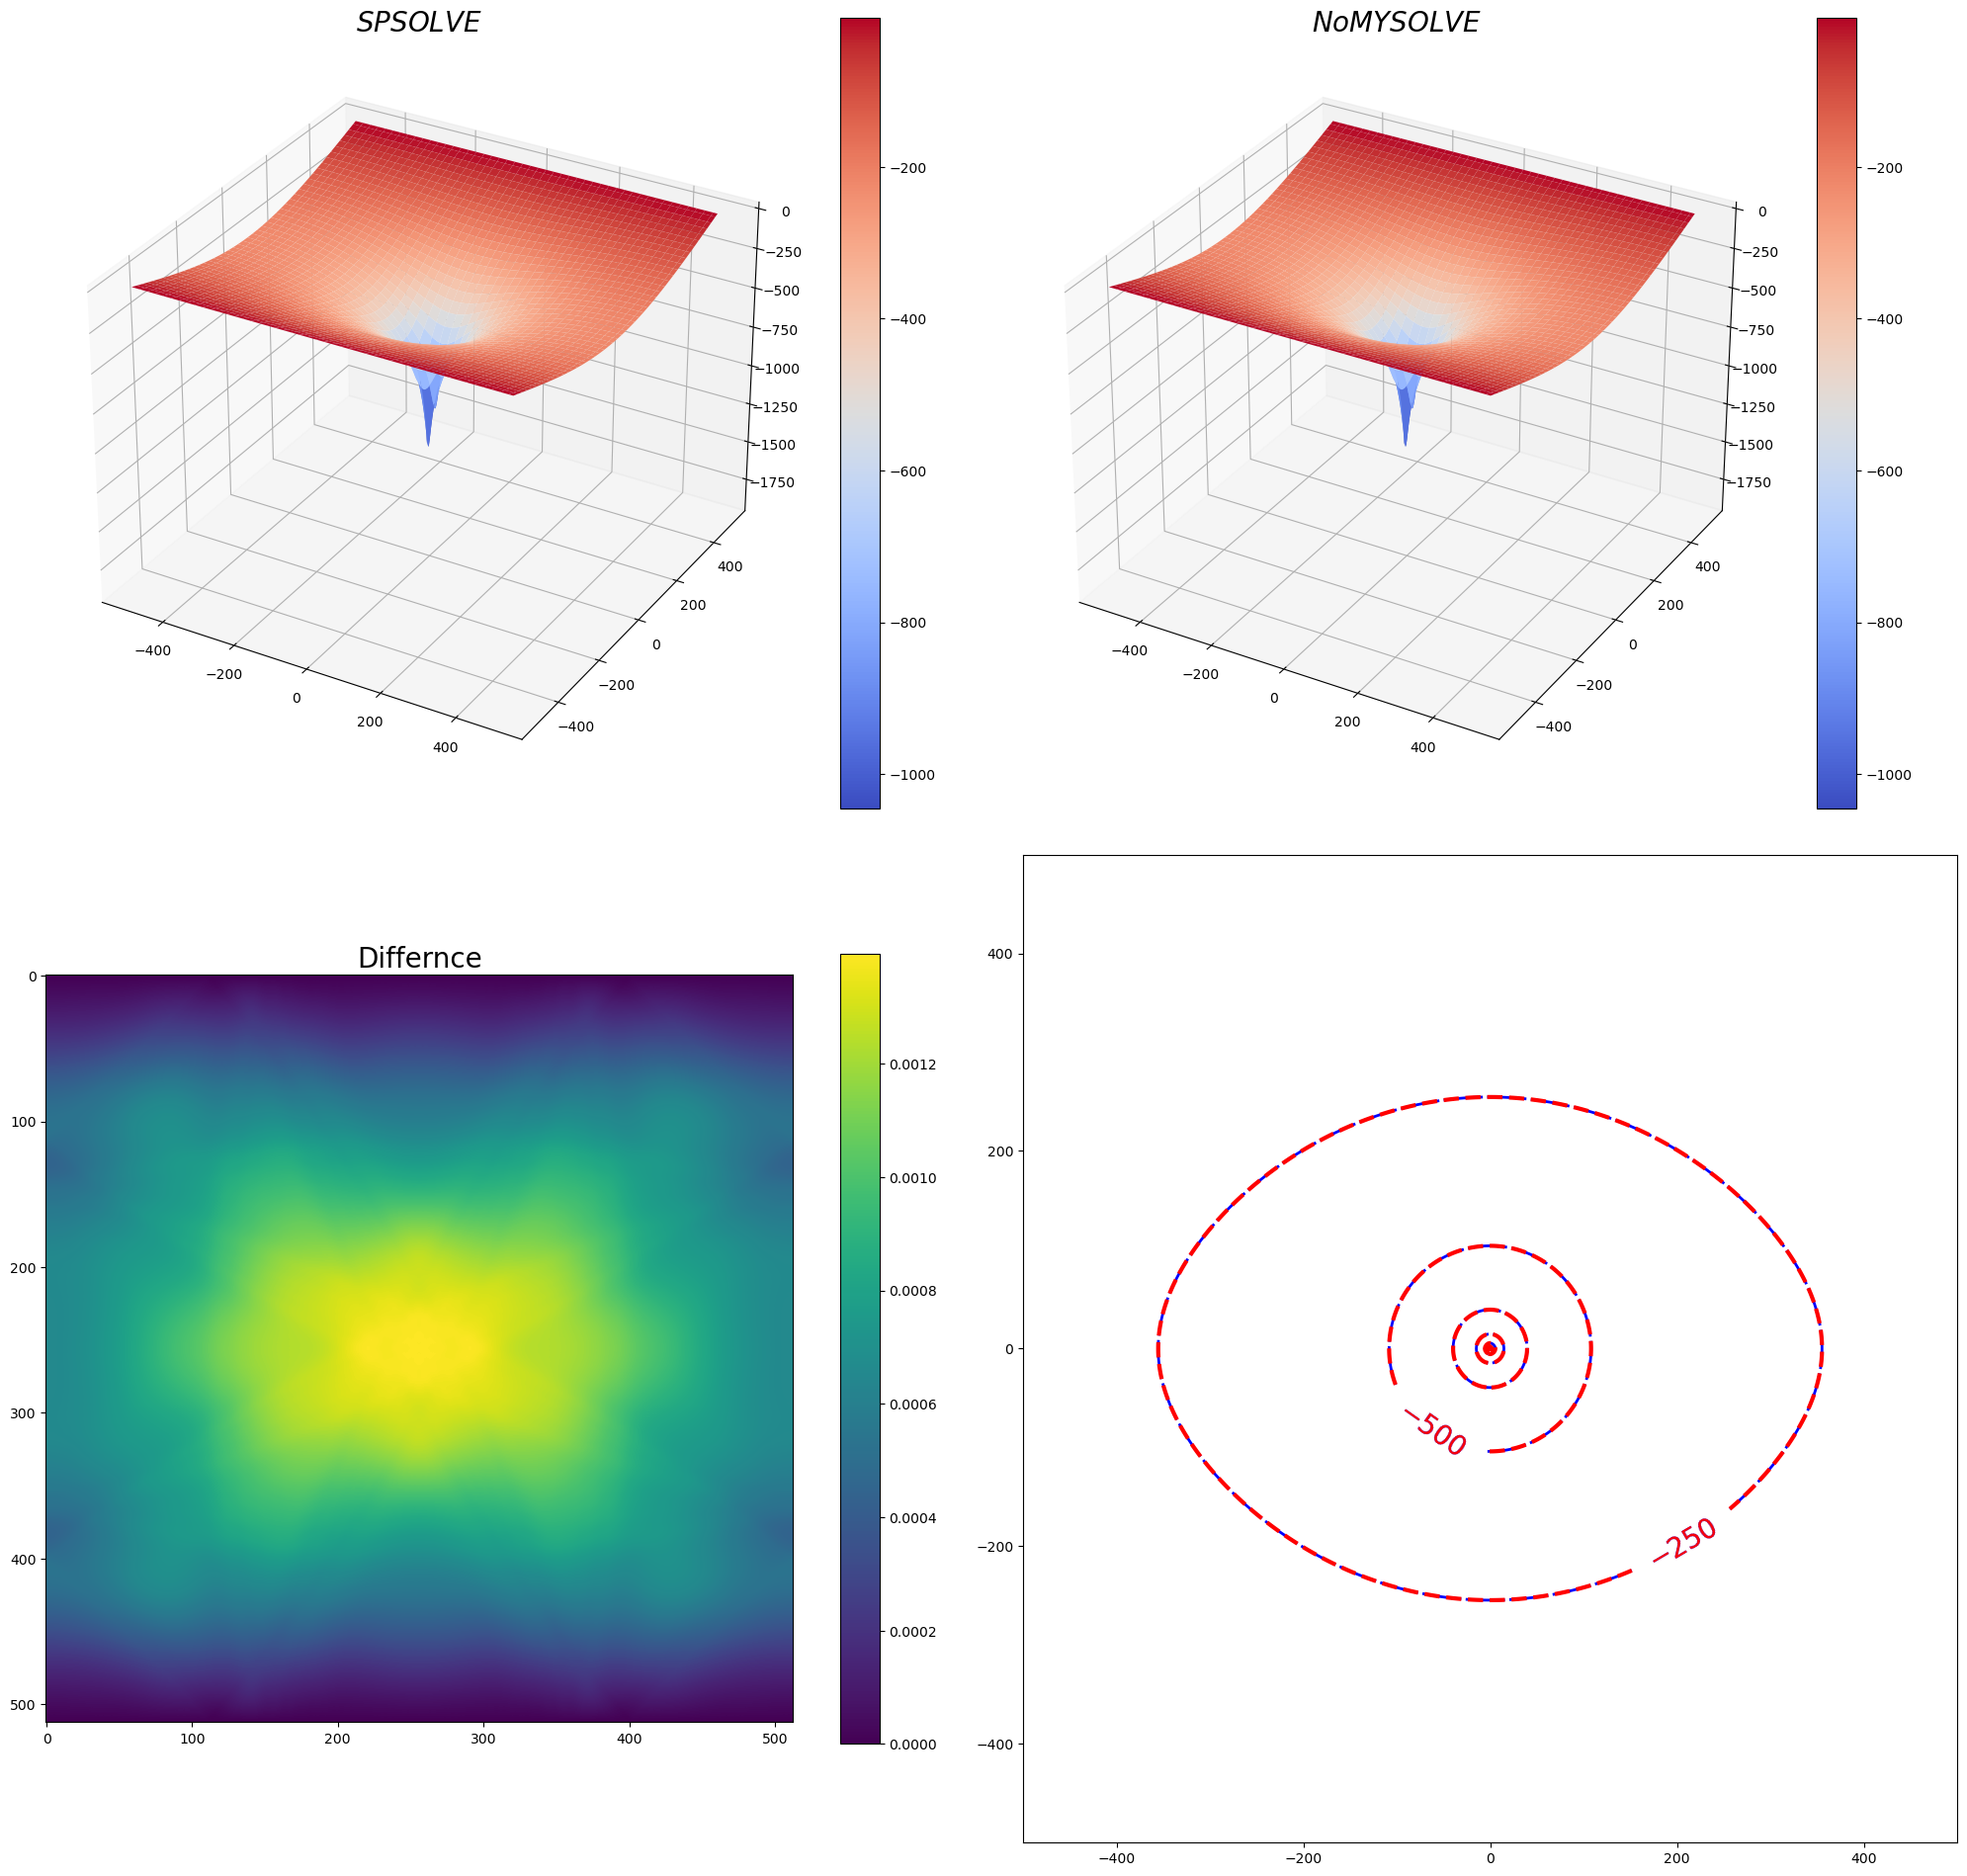

In [47]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.set_title(f'$SPSOLVE$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, w, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$No MYSOLVE$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(np.abs(w - u))
plt.colorbar(im, shrink=0.8, ax=ax3)

ct1 = ax4.contour(xx, yy, w, colors='b', linewidths=2)
ct2 = ax4.contour(xx, yy, u, colors='r', linewidths=3)
ax4.clabel(ct1, inline=True, fontsize=20)
ax4.clabel(ct2, inline=True, fontsize=20)
# h1, _ = ct1.legend_elements()
# h2, _ = ct2.legend_elements()
fig.tight_layout()

In [5]:
def fv_mesh(a, N):
    h = 2*a / N
    left, bottom = -a + h/2, -a + h/2
    right, top = a - h/2, a - h/2
    
    x = np.linspace(left, right, N)
    y = np.linspace(bottom, top, N)
    return np.meshgrid(x, y)

def fv_b_func(a, N, f):
    h = 2*a / N
    xx, yy = fv_mesh(a, N)
    f_mat = f(xx, yy).flatten()
    return f_mat * h * h

def fv_b_point(N):
    b = np.zeros(N*N)
    idx = N//2 + N * (N//2)
    b[idx] = 1
    return b

def fv_A_dirichlet(n):
    n2 = n**2
    A = sparse.lil_matrix((n2, n2))
    # Interior points
    for i in range(1, n-1):
        for j in range(1, n-1):
            idx = i * n + j
            A[idx, idx] = -4
            A[idx, idx+1] = A[idx, idx-1] = A[idx, idx-n] = A[idx, idx+n] = 1
    
    # Boundary points
    for i in range(1, n-1):
        # Top
        idx = i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx+n] = 4/3
        
        # Bottom
        idx = (n-1) * n + i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx-n] = 4/3
        
        # Left
        idx = i * n
        A[idx, idx] = -6
        A[idx, idx+n] = A[idx, idx-n] = 1
        A[idx, idx+1] = 4/3
        
        # Right
        idx = i * n + n - 1
        A[idx, idx] = -6
        A[idx, idx+n] = A[idx, idx-n] = 1
        A[idx, idx-1] = 4/3
        
    # Four corners
    # Left top
    idx = 0
    A[idx, idx] = -8
    A[idx, idx+1] = A[idx, idx+n] = 4/3
    # Right Top
    idx = n-1
    A[idx, idx] = -8
    A[idx, idx-1] = A[idx, idx+n] = 4/3
    # Left Bottom
    idx = (n-1) * n
    A[idx, idx] = -8
    A[idx, idx+1] = A[idx, idx-n] = 4/3
    # Right Bottom
    idx = n2 - 1
    A[idx, idx] = -8
    A[idx, idx-1] = A[idx, idx-n] = 4/3
    
    A = A.tocoo()
    return A


def fv_A_neu(n):
    '''
    Left and Right are neumann, top and down are dirichlet
    '''
    n2 = n**2
    A = sparse.lil_matrix((n2, n2))
    # Interior points
    for i in range(1, n-1):
        for j in range(1, n-1):
            idx = i * n + j
            A[idx, idx] = -4
            A[idx, idx+1] = A[idx, idx-1] = A[idx, idx-n] = A[idx, idx+n] = 1
    
    # Boundary points
    for i in range(1, n-1):
        # Top
        idx = i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx+n] = 4/3
        
        # Bottom
        idx = (n-1) * n + i
        A[idx, idx] = -6
        A[idx, idx+1] = A[idx, idx-1] = 1
        A[idx, idx-n] = 4/3
        
        # Left
        idx = i * n
        A[idx, idx] = -3
        A[idx, idx+n] = A[idx, idx-n] = A[idx, idx+1] = 1
        
        # Right
        idx = i * n + n - 1
        A[idx, idx] = -3
        A[idx, idx+n] = A[idx, idx-n] = A[idx, idx-1] = 1
        
    # Four corners
    
    # Left top
    idx = 0
    A[idx, idx] = -5
    A[idx, idx+n] = 4/3
    A[idx, idx+1] = 1
    
    # Right Top
    idx = n-1
    A[idx, idx] = -5
    A[idx, idx+n] = 4/3
    A[idx, idx-1] = 1
    
    # Left Bottom
    idx = (n-1) * n
    A[idx, idx] = -5
    A[idx, idx-n] = 4/3
    A[idx, idx+1] = 1
    
    # Right Bottom
    idx = n2 - 1
    A[idx, idx] = -5
    A[idx, idx-n] = 4/3
    A[idx, idx-1] = 1
    
    A = A.tocoo()
    return A
        


In [6]:
a = 1
N = 65
h = 2*a/N

f = lambda x, y: normal(x, y, h)
xx, yy = fv_mesh(a, N)
A = fv_A_dirichlet(N).tocsr()
# A = fv_A_neu(N).tocsr()
b = fv_b_point(N)
# b = fv_b_func(a, N, f)
# print(A.todense())
w = spsolve(A, b).reshape(N, N)
# u = jacobi_2nd(A, b).reshape(N ,N)
# u = jacobi_2nd(A, b).reshape(N, N)
# u = sor(A, b, 1.2).reshape(N, N)
u = descent(A, b).reshape(N, N)
# u = ssor(A, b, 1.2).reshape(N, N)

itr:0 Difference: 1.000e+00,  Loss:5.00e-01
itr:1 Difference: 4.472e-01,  Loss:3.75e-01
itr:2 Difference: 2.727e-01,  Loss:3.12e-01
itr:3 Difference: 2.074e-01,  Loss:2.73e-01
itr:4 Difference: 1.628e-01,  Loss:2.46e-01
itr:5 Difference: 1.370e-01,  Loss:2.26e-01
itr:6 Difference: 1.166e-01,  Loss:2.09e-01
itr:7 Difference: 1.027e-01,  Loss:1.96e-01
itr:8 Difference: 9.099e-02,  Loss:1.85e-01
itr:9 Difference: 8.229e-02,  Loss:1.76e-01
itr:10 Difference: 7.467e-02,  Loss:1.68e-01
itr:11 Difference: 6.870e-02,  Loss:1.61e-01
itr:12 Difference: 6.335e-02,  Loss:1.55e-01
itr:13 Difference: 5.899e-02,  Loss:1.49e-01
itr:14 Difference: 5.502e-02,  Loss:1.44e-01
itr:15 Difference: 5.170e-02,  Loss:1.40e-01
itr:16 Difference: 4.864e-02,  Loss:1.36e-01
itr:17 Difference: 4.603e-02,  Loss:1.32e-01
itr:18 Difference: 4.359e-02,  Loss:1.29e-01
itr:19 Difference: 4.148e-02,  Loss:1.25e-01
itr:20 Difference: 3.950e-02,  Loss:1.22e-01
itr:21 Difference: 3.776e-02,  Loss:1.20e-01
itr:22 Difference: 3

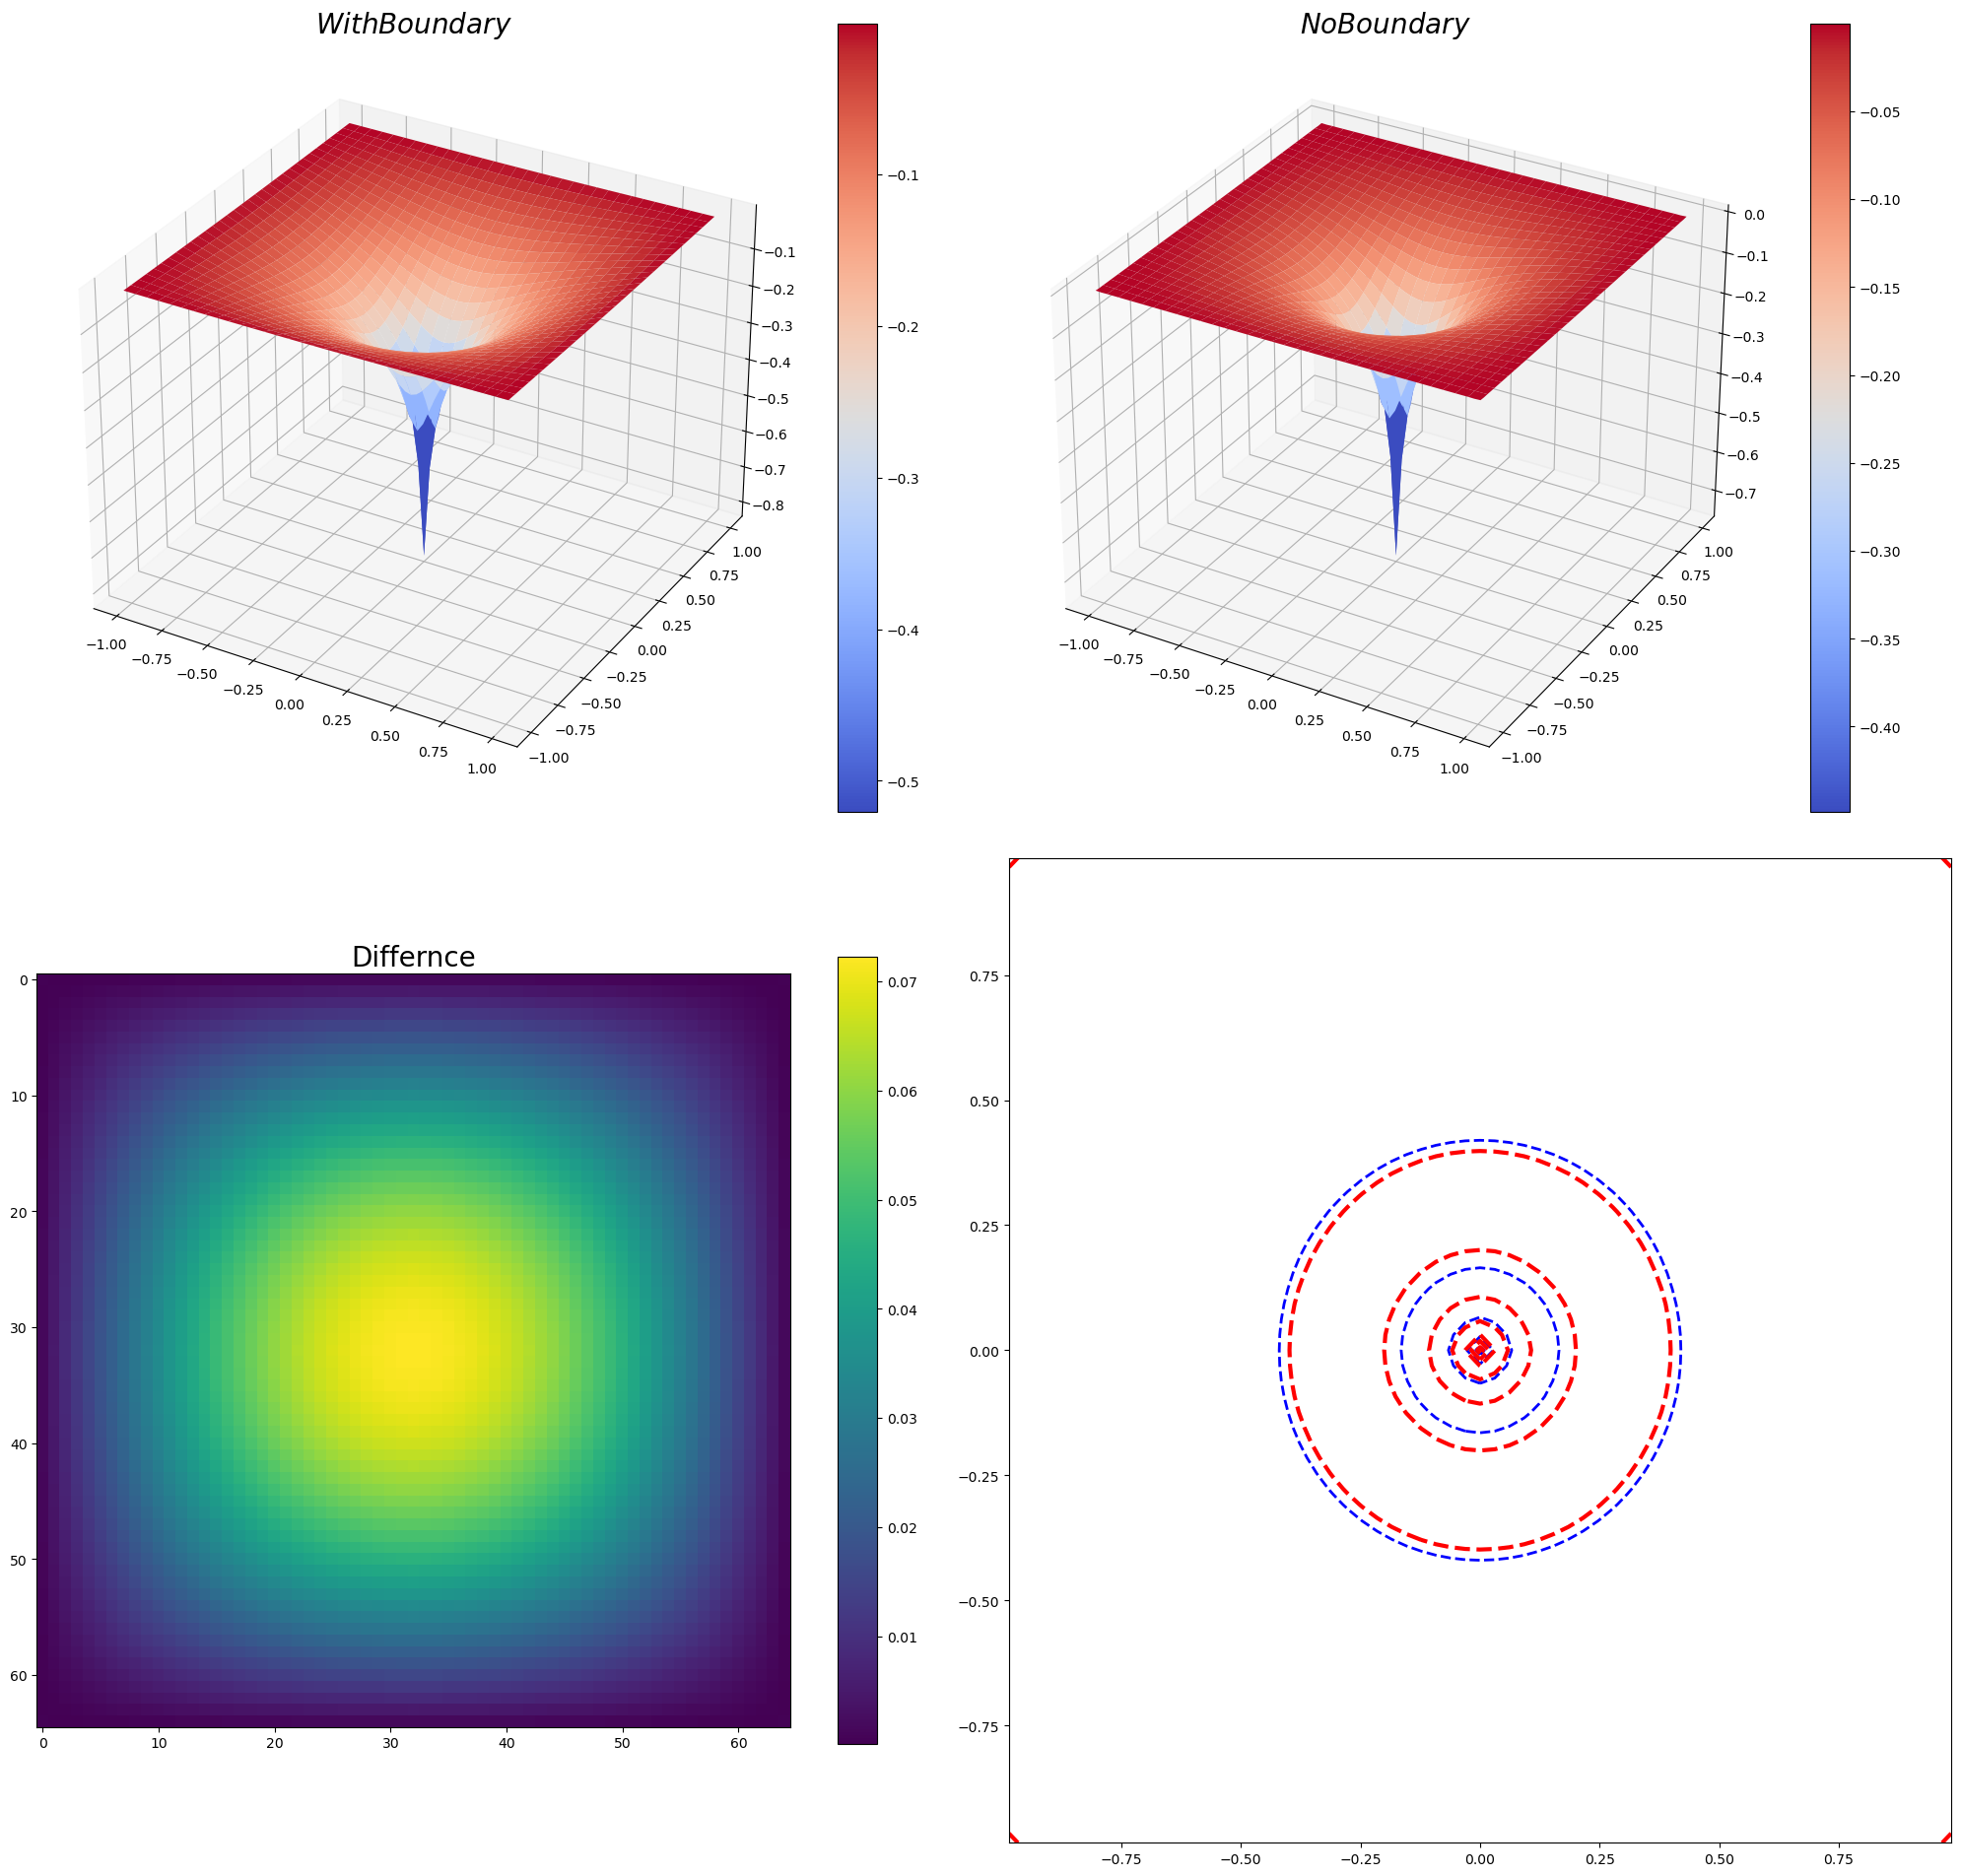

In [7]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.set_title(f'$With Boundary$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, w, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$No Boundary$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(np.abs(w - u))
plt.colorbar(im, shrink=0.8, ax=ax3)

ct1 = ax4.contour(xx, yy, w, colors='b', linewidths=2)
ct2 = ax4.contour(xx, yy, u, colors='r', linewidths=3)

fig.tight_layout()

In [17]:
import torch
from trainer import *
n = 33
a = 1
h = 2/(n-1)
x = np.linspace(-a, a, n)
y = np.linspace(-a, a, n)
xx, yy = np.meshgrid(x, y)
f_mat = normal(xx, yy, h)

A = fd_A_with_bc(33)
D = sparse.diags(A.diagonal())
L = sparse.tril(A, -1)
U = sparse.triu(A, 1)
invM = sparse.linalg.inv(D.tocsc())
M = L + U
A, invM, M = coo2tensor(A), coo2tensor(invM.tocoo()), coo2tensor(M.tocoo())

b = fd_b_bc(f_mat, h)
# b = torch.from_numpy(b.reshape(1, (n-2)*(n-2))).to(torch.float32)
b = torch.from_numpy(b.reshape(1, n*n)).to(torch.float32)

kernel = torch.tensor([[0, 0.25, 0], [0.25, 0, 0.25], [0, 0.25, 0]])
f_tensor = torch.from_numpy(f_mat).to(torch.float32)

In [15]:
def jac(M, invM, x, b):
    Mx = mmbv(M, x)
    x_new = mmbv(invM, (b-Mx))
    return x_new

In [26]:
x = torch.rand(1, 1, 31, 31)
u = pad_diri_bc(x, (1, 1, 1, 1))
# u_jac = jac(M, invM, x.reshape(1, (n-2)*(n-2)), b)
u_jac = jac(M, invM, u.reshape(1, n*n), b)

u_conv = conv_rhs(u, kernel, h, f_tensor[1:-1, 1:-1])
# u_jac = u_jac.reshape(n-2, n-2)
u_jac = u_jac.reshape(n, n)

In [28]:
print(torch.abs(u_jac[1:-1,1:-1]-u_conv).sum())

tensor(0.)


In [32]:
x = torch.rand(3, 5)
torch.norm(x, p=2, dim=1, keepdim=True)

tensor([[1.1379],
        [1.8358],
        [1.3432]])